# 1. Prepare the dataset (TorchDB.py & train.py)

In [1]:
import numpy as np
from math import log10
import math
import matplotlib.pyplot as plt
import os
import sys
from os import listdir
from os.path import join, isdir
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import cupy
import re
from torchvision.utils import save_image as imwrite

In [2]:
# parameters
args = {
    'train': './db',
    'kernel': 51,
    'out_dir': './output_sepconv_pytorch',
    'epochs': 10,
    'batch_size': 4,
    'load_model': None,
    'test_input': './Interpolation_testset/input',
    'gt': './Interpolation_testset/gt',
}

### DBreader reads all triplet set of frames in a directory.  
### Each triplet set contains frame 0, 1, 2.  
### Each image is named frame0.png, frame1.png, frame2.png.  
### Frame 0, 2 are the input and frame 1 is the output. 

In [3]:
class DBreader_frame_interpolation(Dataset):
    
    def __init__(self, db_dir, resize=None):
        if resize is not None:
            self.transform = transforms.Compose([
                transforms.Resize(resize),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor()
            ])

        self.triplet_list = np.array([(db_dir + '/' + f) for f in listdir(db_dir) if isdir(join(db_dir, f))])
        self.file_len = len(self.triplet_list)
        
    def __getitem__(self, index):
        frame0 = self.transform(Image.open(self.triplet_list[index] + "/frame0.png"))
        frame1 = self.transform(Image.open(self.triplet_list[index] + "/frame1.png"))
        frame2 = self.transform(Image.open(self.triplet_list[index] + "/frame2.png"))

        return frame0, frame1, frame2

    def __len__(self):
        return self.file_len


In [4]:
db_dir = args['train']
total_epoch = args['epochs']
batch_size = args['batch_size']

### Read the dataset and Make TrainLoader

In [5]:
dataset = DBreader_frame_interpolation(db_dir, resize=(128, 128))
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Plot the dataset

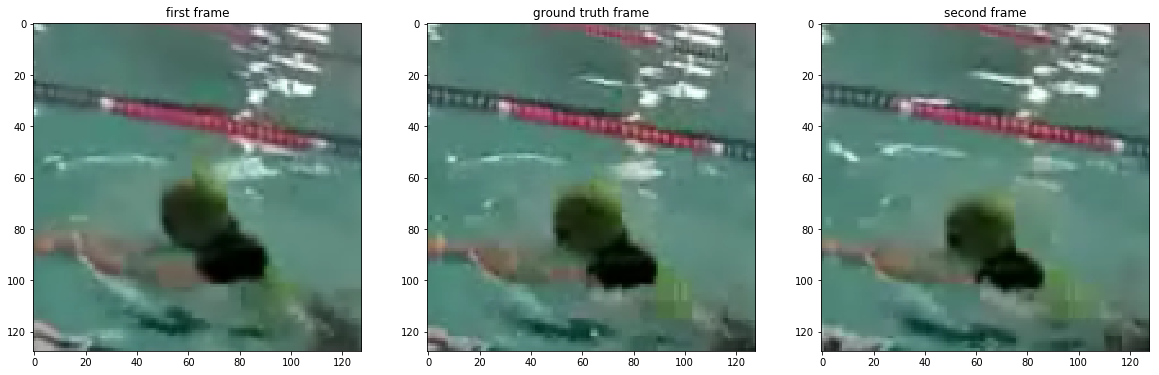

In [6]:
sample = dataset[3]
def plotting(sample):
    fig = plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(sample[0].permute(1, 2, 0)); plt.gca().set_title('first frame')
    plt.subplot(1,3,2); plt.imshow(sample[1].permute(1, 2, 0)); plt.gca().set_title('ground truth frame')
    plt.subplot(1,3,3); plt.imshow(sample[2].permute(1, 2, 0)); plt.gca().set_title('second frame')

plotting(sample)

# 2. Model (mmodel.py & sepconv.py)

<img src="images/Model.png">

In [7]:
def to_variable(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x) 

### __KernelEstimation__ constructs the CNN model as in the figure above 

In [8]:
class KernelEstimation(torch.nn.Module):
    def __init__(self, kernel_size):
        super(KernelEstimation, self).__init__()
        self.kernel_size = kernel_size

        def Basic(input_channel, output_channel):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False)
            )

        def Upsample(channel):
            return torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False)
            )

        def Subnet(ks):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=64, out_channels=ks, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                torch.nn.Conv2d(in_channels=ks, out_channels=ks, kernel_size=3, stride=1, padding=1)
            )

        self.moduleConv1 = Basic(6, 32)
        self.modulePool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv2 = Basic(32, 64)
        self.modulePool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv3 = Basic(64, 128)
        self.modulePool3 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv4 = Basic(128, 256)
        self.modulePool4 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv5 = Basic(256, 512)
        self.modulePool5 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleDeconv5 = Basic(512, 512)
        self.moduleUpsample5 = Upsample(512)

        self.moduleDeconv4 = Basic(512, 256)
        self.moduleUpsample4 = Upsample(256)

        self.moduleDeconv3 = Basic(256, 128)
        self.moduleUpsample3 = Upsample(128)

        self.moduleDeconv2 = Basic(128, 64)
        self.moduleUpsample2 = Upsample(64)

        self.moduleVertical1 = Subnet(self.kernel_size)
        self.moduleVertical2 = Subnet(self.kernel_size)
        self.moduleHorizontal1 = Subnet(self.kernel_size)
        self.moduleHorizontal2 = Subnet(self.kernel_size)

    def forward(self, rfield0, rfield2):
        tensorJoin = torch.cat([rfield0, rfield2], 1)

        tensorConv1 = self.moduleConv1(tensorJoin)
        tensorPool1 = self.modulePool1(tensorConv1)

        tensorConv2 = self.moduleConv2(tensorPool1)
        tensorPool2 = self.modulePool2(tensorConv2)

        tensorConv3 = self.moduleConv3(tensorPool2)
        tensorPool3 = self.modulePool3(tensorConv3)

        tensorConv4 = self.moduleConv4(tensorPool3)
        tensorPool4 = self.modulePool4(tensorConv4)

        tensorConv5 = self.moduleConv5(tensorPool4)
        tensorPool5 = self.modulePool5(tensorConv5)

        tensorDeconv5 = self.moduleDeconv5(tensorPool5)
        tensorUpsample5 = self.moduleUpsample5(tensorDeconv5)

        tensorCombine = tensorUpsample5 + tensorConv5

        tensorDeconv4 = self.moduleDeconv4(tensorCombine)
        tensorUpsample4 = self.moduleUpsample4(tensorDeconv4)

        tensorCombine = tensorUpsample4 + tensorConv4

        tensorDeconv3 = self.moduleDeconv3(tensorCombine)
        tensorUpsample3 = self.moduleUpsample3(tensorDeconv3)

        tensorCombine = tensorUpsample3 + tensorConv3

        tensorDeconv2 = self.moduleDeconv2(tensorCombine)
        tensorUpsample2 = self.moduleUpsample2(tensorDeconv2)

        tensorCombine = tensorUpsample2 + tensorConv2

        Vertical1 = self.moduleVertical1(tensorCombine)
        Vertical2 = self.moduleVertical2(tensorCombine)
        Horizontal1 = self.moduleHorizontal1(tensorCombine)
        Horizontal2 = self.moduleHorizontal2(tensorCombine)

        return Vertical1, Horizontal1, Vertical2, Horizontal2

### Reimplementing a new Autograd function for SepConv

In [9]:
kernel_Sepconv_updateOutput = '''
    extern "C" __global__ void kernel_Sepconv_updateOutput(
        const int n,
        const float* input,
        const float* vertical,
        const float* horizontal,
        float* output
    ) { for (int intIndex = (blockIdx.x * blockDim.x) + threadIdx.x; intIndex < n; intIndex += blockDim.x * gridDim.x) {
        float dblOutput = 0.0;

        const int intSample = ( intIndex / SIZE_3(output) / SIZE_2(output) / SIZE_1(output) ) % SIZE_0(output);
        const int intDepth  = ( intIndex / SIZE_3(output) / SIZE_2(output)                  ) % SIZE_1(output);
        const int intY      = ( intIndex / SIZE_3(output)                                   ) % SIZE_2(output);
        const int intX      = ( intIndex                                                    ) % SIZE_3(output);

        for (int intFilterY = 0; intFilterY < SIZE_1(vertical); intFilterY += 1) {
        for (int intFilterX = 0; intFilterX < SIZE_1(horizontal); intFilterX += 1) {
        dblOutput += VALUE_4(input, intSample, intDepth, intY + intFilterY, intX + intFilterX) * VALUE_4(vertical, intSample, intFilterY, intY, intX) * VALUE_4(horizontal, intSample, intFilterX, intY, intX);
            }
        }

        output[intIndex] = dblOutput;
    } }
'''

kernel_SeparableConvolution_updateGradVertical = '''
    extern "C" __global__ void kernel_SeparableConvolution_updateGradVertical(
        const int n,
        const float* gradLoss,
        const float* input,
        const float* horizontal,
        float* gradVertical
    ) { for (int intIndex = (blockIdx.x * blockDim.x) + threadIdx.x; intIndex < n; intIndex += blockDim.x * gridDim.x) {
        float floatOutput = 0.0;
        float c = 0.0;
    
        const int intBatch   = ( intIndex / SIZE_3(gradVertical) / SIZE_2(gradVertical) / SIZE_1(gradVertical) ) % SIZE_0(gradVertical);
        const int intFilterY = ( intIndex / SIZE_3(gradVertical) / SIZE_2(gradVertical)                        ) % SIZE_1(gradVertical);
        const int intY       = ( intIndex / SIZE_3(gradVertical)                                               ) % SIZE_2(gradVertical);
        const int intX       = ( intIndex                                                                      ) % SIZE_3(gradVertical);
    
        for (int intFilterX = 0; intFilterX < SIZE_1(horizontal); intFilterX++) 
        {
            float product = VALUE_4(gradLoss, intBatch, 0, intY, intX)*              // channel 0
            VALUE_4(input, intBatch, 0, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(horizontal, intBatch, intFilterX, intY, intX) +
            VALUE_4(gradLoss, intBatch, 1, intY, intX)*                          // channel 1     
            VALUE_4(input, intBatch, 1, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(horizontal, intBatch, intFilterX, intY, intX) +
            VALUE_4(gradLoss, intBatch, 2, intY, intX)*                          // channel 2
            VALUE_4(input, intBatch, 2, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(horizontal, intBatch, intFilterX, intY, intX);

            floatOutput += product;
        }
    
        gradVertical[intIndex] = floatOutput;
    } }
'''

kernel_SeparableConvolution_updateGradHorizontal = '''
    extern "C" __global__ void kernel_SeparableConvolution_updateGradHorizontal(
        const int n,
        const float* gradLoss,
        const float* input,
        const float* vertical,
        float* gradHorizontal
    ) { for (int intIndex = (blockIdx.x * blockDim.x) + threadIdx.x; intIndex < n; intIndex += blockDim.x * gridDim.x) {
        float floatOutput = 0.0;
        float c = 0.0;
    
        const int intBatch   = ( intIndex / SIZE_3(gradHorizontal) / SIZE_2(gradHorizontal) / SIZE_1(gradHorizontal) ) % SIZE_0(gradHorizontal);
        const int intFilterX = ( intIndex / SIZE_3(gradHorizontal) / SIZE_2(gradHorizontal)                          ) % SIZE_1(gradHorizontal);
        const int intY       = ( intIndex / SIZE_3(gradHorizontal)                                                   ) % SIZE_2(gradHorizontal);
        const int intX       = ( intIndex                                                                            ) % SIZE_3(gradHorizontal);
    
        for (int intFilterY = 0; intFilterY < SIZE_1(vertical); intFilterY++)
        {
            float product = VALUE_4(gradLoss, intBatch, 0, intY, intX)*             // channel 0
            VALUE_4(input, intBatch, 0, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(vertical, intBatch, intFilterY, intY, intX) + 
            VALUE_4(gradLoss, intBatch, 1, intY, intX)*                         // channel 1
            VALUE_4(input, intBatch, 1, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(vertical, intBatch, intFilterY, intY, intX) + 
            VALUE_4(gradLoss, intBatch, 2, intY, intX)*                         // channel 2
            VALUE_4(input, intBatch, 2, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(vertical, intBatch, intFilterY, intY, intX);
    
            float y = product - c;
            float t = floatOutput + y;
            c = (t - floatOutput) - y;
            floatOutput = t;
        }
    
        gradHorizontal[intIndex] = floatOutput;
    } }
'''

In [10]:
def cupy_kernel(strFunction, objectVariables):
    strKernel = globals()[strFunction]

    while True:
        objectMatch = re.search('(SIZE_)([0-4])(\()([^\)]*)(\))', strKernel)

        if objectMatch is None:
            break
        # end

        intArg = int(objectMatch.group(2))

        strTensor = objectMatch.group(4)
        intSizes = objectVariables[strTensor].size()

        strKernel = strKernel.replace(objectMatch.group(), str(intSizes[intArg]))
    # end

    while True:
        objectMatch = re.search('(VALUE_)([0-4])(\()([^\)]+)(\))', strKernel)

        if objectMatch is None:
            break
        # end

        intArgs = int(objectMatch.group(2))
        strArgs = objectMatch.group(4).split(',')

        strTensor = strArgs[0]
        intStrides = objectVariables[strTensor].stride()
        strIndex = ['((' + strArgs[intArg + 1].replace('{', '(').replace('}', ')').strip() + ')*' + str(intStrides[intArg]) + ')' for intArg in range(intArgs)]

        strKernel = strKernel.replace(objectMatch.group(0), strTensor + '[' + str.join('+', strIndex) + ']')
    # end

    return strKernel

In [11]:
@cupy.util.memoize(for_each_device=True)
def cupy_launch(strFunction, strKernel):
    return cupy.cuda.compile_with_cache(strKernel).get_function(strFunction)

In [12]:
class FunctionSepconv(torch.autograd.Function):
    def __init__(self):
        super(FunctionSepconv, self).__init__()

    # end

    def forward(self, input, vertical, horizontal):
        self.save_for_backward(input, vertical, horizontal)

        intSample = input.size(0)
        intInputDepth = input.size(1)
        intInputHeight = input.size(2)
        intInputWidth = input.size(3)
        intFilterSize = min(vertical.size(1), horizontal.size(1))
        intOutputHeight = min(vertical.size(2), horizontal.size(2))
        intOutputWidth = min(vertical.size(3), horizontal.size(3))

        assert (intInputHeight - intFilterSize == intOutputHeight - 1)
        assert (intInputWidth - intFilterSize == intOutputWidth - 1)

        assert (input.is_contiguous() == True)
        assert (vertical.is_contiguous() == True)
        assert (horizontal.is_contiguous() == True)

        output = input.new_zeros(intSample, intInputDepth, intOutputHeight, intOutputWidth)

        if input.is_cuda == True:
            class Stream:
                ptr = torch.cuda.current_stream().cuda_stream

            # end

            n = output.nelement()
            cupy_launch('kernel_Sepconv_updateOutput', cupy_kernel('kernel_Sepconv_updateOutput', {
                'input': input,
                'vertical': vertical,
                'horizontal': horizontal,
                'output': output
            }))(
                grid=tuple([int((n + 512 - 1) / 512), 1, 1]),
                block=tuple([512, 1, 1]),
                args=[n, input.data_ptr(), vertical.data_ptr(), horizontal.data_ptr(), output.data_ptr()],
                stream=Stream
            )

        elif input.is_cuda == False:
            raise NotImplementedError()

        # end

        return output

    # end

    def backward(self, gradOutput):
        input, vertical, horizontal = self.saved_tensors

        intSample = input.size(0)
        intInputDepth = input.size(1)
        intInputHeight = input.size(2)
        intInputWidth = input.size(3)
        intFilterSize = min(vertical.size(1), horizontal.size(1))
        intOutputHeight = min(vertical.size(2), horizontal.size(2))
        intOutputWidth = min(vertical.size(3), horizontal.size(3))

        assert (intInputHeight - intFilterSize == intOutputHeight - 1)
        assert (intInputWidth - intFilterSize == intOutputWidth - 1)

        assert (gradOutput.is_contiguous() == True)

        gradInput = input.new_zeros(intSample, intInputDepth, intInputHeight, intInputWidth) if self.needs_input_grad[0] == True else None
        gradVertical = input.new_zeros(intSample, intFilterSize, intOutputHeight, intOutputWidth) if self.needs_input_grad[1] == True else None
        gradHorizontal = input.new_zeros(intSample, intFilterSize, intOutputHeight, intOutputWidth) if self.needs_input_grad[2] == True else None

        if input.is_cuda == True:
            class Stream:
                ptr = torch.cuda.current_stream().cuda_stream

            # end

            # vertical grad
            n_v = gradVertical.nelement()
            cupy_launch('kernel_SeparableConvolution_updateGradVertical', cupy_kernel('kernel_SeparableConvolution_updateGradVertical', {
                'gradLoss': gradOutput,
                'input': input,
                'horizontal': horizontal,
                'gradVertical': gradVertical
            }))(
                grid=tuple([int((n_v + 512 - 1) / 512), 1, 1]),
                block=tuple([512, 1, 1]),
                args=[n_v, gradOutput.data_ptr(), input.data_ptr(), horizontal.data_ptr(), gradVertical.data_ptr()],
                stream=Stream
            )

            # horizontal grad
            n_h = gradHorizontal.nelement()
            cupy_launch('kernel_SeparableConvolution_updateGradHorizontal', cupy_kernel('kernel_SeparableConvolution_updateGradHorizontal', {
                'gradLoss': gradOutput,
                'input': input,
                'vertical': vertical,
                'gradHorizontal': gradHorizontal
            }))(
                grid=tuple([int((n_h + 512 - 1) / 512), 1, 1]),
                block=tuple([512, 1, 1]),
                args=[n_h, gradOutput.data_ptr(), input.data_ptr(), vertical.data_ptr(), gradHorizontal.data_ptr()],
                stream=Stream
            )

        elif input.is_cuda == False:
            raise NotImplementedError()

        # end

        return gradInput, gradVertical, gradHorizontal

### Put everything together

In [13]:
class SepConvNet(torch.nn.Module):
    def __init__(self, kernel_size):
        super(SepConvNet, self).__init__()
        self.kernel_size = kernel_size
        self.kernel_pad = int(math.floor(kernel_size / 2.0))

        self.epoch = Variable(torch.tensor(0, requires_grad=False))
        self.get_kernel = KernelEstimation(self.kernel_size)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.criterion = torch.nn.MSELoss()

        self.modulePad = torch.nn.ReplicationPad2d([self.kernel_pad, self.kernel_pad, self.kernel_pad, self.kernel_pad])

    def forward(self, frame0, frame2):
        h0 = int(list(frame0.size())[2])
        w0 = int(list(frame0.size())[3])
        h2 = int(list(frame2.size())[2])
        w2 = int(list(frame2.size())[3])
        if h0 != h2 or w0 != w2:
            sys.exit('Frame sizes do not match')

        h_padded = False
        w_padded = False
        if h0 % 32 != 0:
            pad_h = 32 - (h0 % 32)
            frame0 = F.pad(frame0, (0, 0, 0, pad_h))
            frame2 = F.pad(frame2, (0, 0, 0, pad_h))
            h_padded = True

        if w0 % 32 != 0:
            pad_w = 32 - (w0 % 32)
            frame0 = F.pad(frame0, (0, pad_w, 0, 0))
            frame2 = F.pad(frame2, (0, pad_w, 0, 0))
            w_padded = True

        Vertical1, Horizontal1, Vertical2, Horizontal2 = self.get_kernel(frame0, frame2)

        tensorDot1 = FunctionSepconv()(self.modulePad(frame0), Vertical1, Horizontal1)
        tensorDot2 = FunctionSepconv()(self.modulePad(frame2), Vertical2, Horizontal2)

        frame1 = tensorDot1 + tensorDot2

        if h_padded:
            frame1 = frame1[:, :, 0:h0, :]
        if w_padded:
            frame1 = frame1[:, :, :, 0:w0]

        return frame1

    def train_model(self, frame0, frame2, frame1):
        self.optimizer.zero_grad()
        output = self.forward(frame0, frame2)
        loss = self.criterion(output, frame1)
        loss.backward()
        self.optimizer.step()
        return loss

    def increase_epoch(self):
        self.epoch += 1

# 3. Training (train.py) & Evaluating (TestModule.py)

### Create needed folders

In [14]:
db_dir = args["train"]

if not os.path.exists(args['out_dir']):
    os.makedirs(args['out_dir'])
    
result_dir = args['out_dir'] + '/result'
ckpt_dir = args['out_dir'] + '/checkpoint'

if not os.path.exists(result_dir):
    os.makedirs(result_dir)
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
test_output_dir = args['out_dir'] + '/result'

### Write to log file

In [15]:
logfile = open(args['out_dir'] + '/log.txt', 'w')
logfile.write('batch_size: ' + str(args['batch_size']) + '\n')

14

### Get the parameters & the SepConv model

In [16]:
total_epoch = args['epochs']
batch_size = args['batch_size']

In [17]:
if args['load_model'] is not None:
    checkpoint = torch.load(args['load_model'])
    kernel_size = checkpoint['kernel_size']
    model = SepConvNet(kernel_size=kernel_size)
    state_dict = checkpoint['state_dict']
    model.load_state_dict(state_dict)
    model.epoch = checkpoint['epoch']
else:
    kernel_size = args['kernel']
    model = SepConvNet(kernel_size=kernel_size)

In [18]:
logfile.write('kernel_size: ' + str(kernel_size) + '\n')

16

In [19]:
if torch.cuda.is_available():
    model = model.cuda()

In [20]:
max_step = train_loader.__len__()
max_step

2

### Note on model.train() vs model.eval()
There are two ways of letting the model know your intention i.e do you want to train the model or do you want to use the model to evaluate.  
In case of __model.train()__ the model knows it has to learn the layers and when we use __model.eval()__ it indicates the model that nothing new is to be learnt and the model is used for testing.  
__model.eval()__ is also necessary because in pytorch if we are using batchnorm and during test if we want to just pass a single image, pytorch throws an error if __model.eval()__ is not specified.    
Furthermore, if your network has a dropout layer, then before you use the network to compute output values, you must explicitly set the network into __eval()__ mode. The reason is that during training a dropout layer randomly sets some of its input to zero, which effectively erases them from the network, which makes the final trained network more robust and less prone to overfitting.

## Now let's take a look on the model that we just created

In [21]:
model

SepConvNet(
  (get_kernel): KernelEstimation(
    (moduleConv1): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
    (modulePool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (moduleConv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
    (modulePool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (moduleConv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride

## Middleburry_other is used to evaluate the model on the Middleburry dataset after some training epoch

In [22]:
class Middlebury_other:
    def __init__(self, input_dir, gt_dir):
        self.im_list = ['Beanbags', 'Dimetrodon', 'DogDance', 'Grove2', 'Grove3', 'Hydrangea', 'MiniCooper', 'RubberWhale', 'Urban2', 'Urban3', 'Venus', 'Walking']
        self.transform = transforms.Compose([transforms.ToTensor()])

        self.input0_list = []
        self.input1_list = []
        self.gt_list = []
        for item in self.im_list:
            self.input0_list.append(to_variable(self.transform(Image.open(input_dir + '/' + item + '/frame10.png')).unsqueeze(0)))
            self.input1_list.append(to_variable(self.transform(Image.open(input_dir + '/' + item + '/frame11.png')).unsqueeze(0)))
            self.gt_list.append(to_variable(self.transform(Image.open(gt_dir + '/' + item + '/frame10i11.png')).unsqueeze(0)))

    def Test(self, model, output_dir, logfile=None, output_name='output.png'):
        av_psnr = 0
        if logfile is not None:
            logfile.write('{:<7s}{:<3d}'.format('Epoch: ', model.epoch.item()) + '\n')
        for idx in range(len(self.im_list)):
            if not os.path.exists(output_dir + '/' + self.im_list[idx]):
                os.makedirs(output_dir + '/' + self.im_list[idx])
            frame_out = model(self.input0_list[idx], self.input1_list[idx])
            gt = self.gt_list[idx]
            psnr = -10 * log10(torch.mean((gt - frame_out) * (gt - frame_out)).item())
            av_psnr += psnr
            imwrite(frame_out, output_dir + '/' + self.im_list[idx] + '/' + output_name, range=(0, 1))
            msg = '{:<15s}{:<20.16f}'.format(self.im_list[idx] + ': ', psnr) + '\n'
            print(msg, end='')
            if logfile is not None:
                logfile.write(msg)
        av_psnr /= len(self.im_list)
        msg = '{:<15s}{:<20.16f}'.format('Average: ', av_psnr) + '\n'
        print(msg, end='')
        if logfile is not None:
            logfile.write(msg)
            
    def get_input0_list(self):
        return self.input0_list
    
    def get_input1_list(self):
        return self.input1_list
    
    def get_gt_list(self):
        return self.gt_list

size of an image after being transformed into a tensor for training: torch.Size([1, 3, 480, 640])
length of the test set: 12


Text(0.5, 1.0, 'second frame')

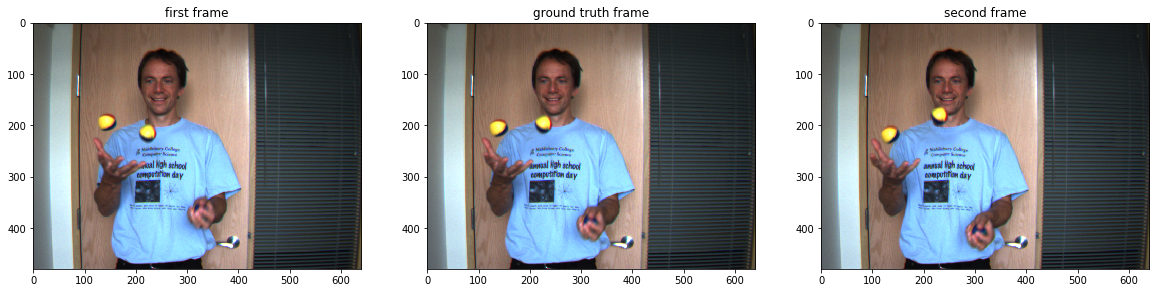

In [23]:
TestDB = Middlebury_other(args['test_input'], args['gt'])
transform = transforms.Compose([transforms.ToTensor()])
print("size of an image after being transformed into a tensor for training:", \
      to_variable(transform(Image.open(args['test_input'] + '/' + 'Beanbags' + '/frame10.png')).unsqueeze(0)).shape)

input0_test_list = TestDB.get_input0_list()
input1_test_list = TestDB.get_input1_list()
gt_test_list = TestDB.get_gt_list()
print("length of the test set:", len(input0_test_list))

# plotting the test set
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(input0_test_list[0][0].cpu().permute(1, 2, 0)); plt.gca().set_title('first frame')
plt.subplot(1,3,2); plt.imshow(gt_test_list[0][0].cpu().permute(1, 2, 0)); plt.gca().set_title('ground truth frame')
plt.subplot(1,3,3); plt.imshow(input1_test_list[0][0].cpu().permute(1, 2, 0)); plt.gca().set_title('second frame')

### Training
Require a lot of memory to store input data, weight parameters and activations as an input propagates through the network. This can lead to out_of_memory on GPU 

In [25]:
while True:
    if model.epoch.item() == total_epoch:
        break
    model.train() # tell the model that we are in the training mode
    for batch_idx, (frame0, frame1, frame2) in enumerate(train_loader):
        frame0 = to_variable(frame0)
        frame1 = to_variable(frame1)
        frame2 = to_variable(frame2)
        loss = model.train_model(frame0, frame2, frame1)
        if batch_idx % 100 == 0:
            print('{:<13s}{:<14s}{:<6s}{:<16s}{:<12s}{:<20.16f}'.format( \
                    'Train Epoch: ', '[' + str(model.epoch.item()) + '/' + str(total_epoch) + ']', \
                    'Step: ', '[' + str(batch_idx) + '/' + str(max_step) + ']', \
                    'train loss: ', loss.item()))
    model.increase_epoch()
    if model.epoch.item() % 1 == 0:
        # save the model
        torch.save({'epoch': model.epoch, 'state_dict': model.state_dict(), \
                    'kernel_size': kernel_size}, ckpt_dir + '/model_epoch' + str(model.epoch.item()).zfill(3) + '.pth')
        print("-----Evaluating-----")
        model.eval() # tell the model that we are evaluating
        TestDB.Test(model, test_output_dir, logfile, str(model.epoch.item()).zfill(3) + '.png')
        logfile.write('\n')
print("-----Done-----")
logfile.close()

-----Done-----


# 4. Testing

In [ ]:
class myTest:
    def __init__(self, input_dir, output_dir):
        self.transform = transforms.Compose([transform.ToTensor()])
        self.input0_list = []
        self.input1_list = []
        
        

In [35]:
_,_,input_files = next(os.walk(os.path.join(os.getcwd(), 'my_testset', 'input')))
len(input_files)

0